In [1]:
from astropy.io import ascii

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import numpy as np
import astropy.units as u

from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline
import palettable

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from code.aux import *

In [2]:
pgf_with_rc_fonts = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 16,               # LaTeX default is 10pt font.
    "font.size": 14,
    "legend.fontsize": 12,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_rc_fonts)
# full page plot:
figwidth  = 30/ 2.54 

# half page plot:
#figwidth  = 16 / 2.54 

# half page plot:
#figwidth  = 11.6 / 2.54 

# ratio:
ratio = 0.65

image_resolution = 5000

figheight  = ratio * figwidth

from palettable.scientific.sequential import Oslo_9 as colormap

#from palettable.colorbrewer.qualitative import Dark2_7 as colormap
#from palettable.cartocolors.qualitative import Bold_4 as colormap
#from palettable.colorbrewer.qualitative import Set1_4 as colormap


cmap = colormap.get_mpl_colormap()
cmap = mpl.cm.get_cmap("bone").copy()
cmap.set_under("w") # sets background to white

energy_unit = 'TeV'      

In [3]:
instrument_dict = table_to_dict(ascii.read("./legend_instruments.ecsv"),'shortname', 'longname')
channel_dict = table_to_dict(ascii.read("./legend_channels.ecsv"),'shortname', 'latex')
target_dict = table_to_dict(ascii.read("./legend_targets.ecsv"),'shortname', 'longname')

In [17]:
import logging
import pandas as pd

import glob
files_all = []
for name in instrument_dict.keys():
    files_all.append(glob.glob("bounds/"+ name +"/*.ecsv"))
files_all = [x for row in files_all for x in row]



metadata_df = pd.DataFrame(columns=('Instrument', 'Target', 'Mode', 'Channel', 'Year', 'Observation time','Title', 'DOI', 'Arxiv', 'File name'))

for i,file in enumerate(files_all):
    filename = file.split("/")[-1][:-5]
    
    file_inst_name = filename.split("_")[0]
    file_year = filename.split("_")[1]
    file_target = filename.split("_")[2]
    file_mode = filename.split("_")[3]
    file_channel = filename.split("_")[4]

    metadata = ascii.read(file).meta
    
    if metadata['instrument'][:10] == 'multi-inst':
        instruments = metadata['instrument'].split("-")[2:]
        meta_inst_name = 'multi-inst'
        file_inst_name = meta_inst_name
    else:
        meta_inst_name = metadata['instrument']
        instruments = metadata['instrument']

    if metadata['source'][:5] == 'multi':
        target_info = metadata['source'].split("-")
        meta_target = target_info[0]        
    else:
        meta_target = metadata['source']
        target_info = metadata['source']
        
    try:
        assert meta_inst_name == file_inst_name
    except:
        logging.warning("Instrument name not consistent in " + str(file))
    try:
        assert metadata['year'] == file_year
    except:
        logging.warning("Year not consistent in " + str(file))
    try:
        assert meta_target == file_target
    except:
        logging.warning("Target name not consistent in " + str(file))
    try:
        assert metadata['channel'] == file_channel
    except:
        logging.warning("Channel name not consistent in " + str(file))

    metadata_df.loc[i] = [instruments, target_info, file_mode, metadata['channel'], metadata['year'], 
                 metadata['obs_time'], metadata['reference'], metadata['doi'], metadata['arxiv'], file]


In [18]:
inst_list = list(instrument_dict.values())
inst_list.append('all')

channel_list = list(channel_dict.keys())
channel_list.append('all')

In [19]:
def filter_list(Mode, Instrument, Channel):
    
    metadata_filtered_df = pd.DataFrame()
    
    if Mode == 'all':
        metadata_filtered_df =  metadata_df
    else:
        metadata_filtered_df = metadata_df.loc[metadata_df['Mode'] == Mode[:3]]

    if Instrument == 'all':
        metadata_filtered_df =  metadata_filtered_df
    else:
        inst_key = get_key_from_value(instrument_dict, Instrument)[0]
        if inst_key == 'multi-inst':
            metadata_filtered_df = metadata_filtered_df.loc[metadata_filtered_df['Instrument'].apply(type) == list]
        else:
            metadata_filtered_df = metadata_filtered_df.loc[metadata_filtered_df['Instrument'] == inst_key]

    if Channel == 'all':
        metadata_filtered_df =  metadata_filtered_df
    else:
        metadata_filtered_df = metadata_filtered_df.loc[metadata_filtered_df['Channel'] == Channel]
        
    print("\n" + str(len(metadata_filtered_df)) + " data sets found. Please select sets to plot.")
    
    labels = []
    
    for index, row in metadata_filtered_df.iterrows():
        label_str = ''
        label_str += get_names_str(row['Instrument'], instrument_dict)
        label_str += ' (' + row['Year'] + ') ' + get_names_str(row['Target'], target_dict) + ', ' + row['Channel']
        labels.append(label_str)
    
    
    checkboxes = [widgets.Checkbox(value=False, description=label, layout=widgets.Layout(width='100%', flex_flow='wrap')) for label in labels]
    output = widgets.VBox(children=checkboxes)
    display(output)

    #metadata_filtered_df = metadata_filtered_df.loc[[k.value for k in checkboxes]]
    return metadata_filtered_df, checkboxes

def filter_list_interactive():
    return interactive(filter_list, Mode=['annihilation', 'decay', 'all'], Instrument=inst_list, Channel=channel_list)


In [20]:
from ipywidgets import interactive
filter_widget = filter_list_interactive()
display(filter_widget)

interactive(children=(Dropdown(description='Mode', options=('annihilation', 'decay', 'all'), value='annihilati…

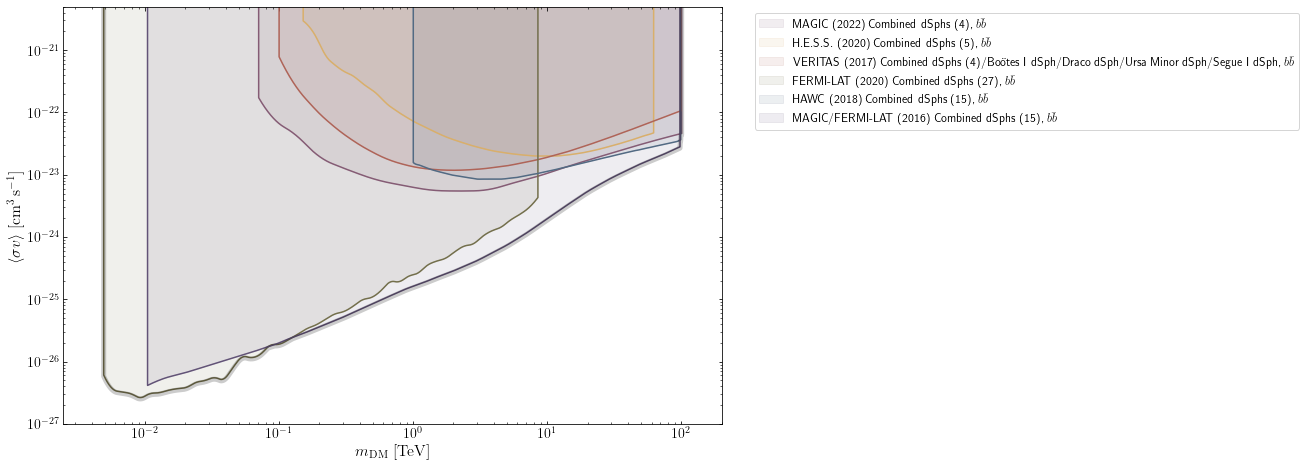

In [22]:
metadata_filtered_df = filter_widget.result[0].loc[[k.value for k in filter_widget.result[1]]]

data_raw_vec = []
labels_plot = []
xmin = 1e6*u.TeV
xmax = 1e-6*u.TeV
for index, row in metadata_filtered_df.iterrows():
    data_raw = ascii.read(row['File name'])
    if row['Mode'] == 'ann':
        yaxis = 'sigmav'
    else:
        yaxis = 'tau'
    data_raw_vec.append([data_raw['mass'], data_raw[yaxis]])
    if min(data_raw['mass'].to('TeV')) < xmin: xmin = min(data_raw['mass'].to('TeV'))
    if max(data_raw['mass'].to('TeV')) > xmax: xmax = max(data_raw['mass'].to('TeV'))

    label_str = r''
    label_str += get_names_str(row['Instrument'], instrument_dict)
    label_str += ' (' + row['Year'] + ') ' + get_names_str(row['Target'], target_dict) + ', $' + get_names_str(row['Channel'], channel_dict) + '$'
    labels_plot.append(label_str)
                
xmin /= 2
xmax *= 2
x_grid = make_grid(xmin, xmax, npoints=2000, unit=energy_unit, log=True)
n_plot =  len(data_raw_vec)

data_to_plot = []
for index in range(n_plot):

    data_gridded = data_on_grid(data_raw_vec[index][0], data_raw_vec[index][1], x_grid, interpolation_kind='quadratic', fill_value = 1e40)
    data_to_plot.append(data_gridded)
    
envelope= []
for i in range(len(x_grid)):
    minvals = []
    for j in range(len(data_to_plot)):
        val = data_to_plot[j][i].value
        if np.isnan(val): val =1e40
        minvals.append(val)
    envelope.append(0.95*min(minvals))

plot_limits = plt.figure(figsize=(figwidth, figheight))
cmap = mpl.colors.ListedColormap(palettable.cartocolors.qualitative.Antique_10.mpl_colors)

for j in range(n_plot):
    plt.plot(x_grid, data_to_plot[j], color=cmap.colors[j])
    plt.fill_between(x_grid.value, data_to_plot[j].value, np.ones(len(x_grid)), alpha=0.1, color=cmap.colors[j], label=labels_plot[j])
    #plt.text(data_fermi2020['mass'].to(energy_unit)[0].value, 0.9*ymax,  "Fermi-LAT (2020)", horizontalalignment='right', verticalalignment='top', snap=True, color=cmap.colors[0], rotation=90)
    
plt.plot(x_grid, envelope, linewidth=5, color='k', alpha=0.2)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-27,5e-21])
plt.xlim([xmin.to(energy_unit).value, xmax.to(energy_unit).value]);

plt.xlabel(r'$m_{\mathrm{DM}}$ $\mathrm{[' +energy_unit + ']}$');
plt.ylabel(r'$\langle\sigma v \rangle$ $[\mathrm{cm^3\,s^{-1}}]$');

In [ ]:
png_name = "limits.png"
plot_limits.savefig(png_name, format='png', dpi=300, bbox_inches="tight")